In [ ]:
from nbdev import *
%nbdev_default_export architectures

Cells will be exported to pct.architectures,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Architectures

> Classes to create hierachy architectures from array configurations.

In [ ]:
%nbdev_hide
import sys
sys.path.append("..")

In [ ]:
%nbdev_export
import random
import numpy as np
import json
import os
from abc import ABC, abstractmethod

from pct.hierarchy import PCTHierarchy
from pct.nodes import PCTNode
from pct.functions import WeightedSum
from pct.functions import IndexedParameter
from pct.functions import Constant
from pct.environments import PendulumV0

In [ ]:
%nbdev_export
class BaseArchitecture(ABC):
    "Base class of an array architecture. This class is not used direclty by developers, but defines the functionality common to all."
    def __init__(self, name, config, env, inputs):
        self.config = config      
        self.env = env
        self.inputs=inputs
        self.hpct = PCTHierarchy()
        self.hpct.add_preprocessor(env)
        
        for input in inputs:
            self.hpct.add_preprocessor(input)
        
    def __call__(self):
        level0config = self.config['level0']
        previous_columns=self.configure_zerothlevel()
        
        intermediate_levels = len(self.config)-2
        level=-1
        for level in range(intermediate_levels):
            leveln = self.config[f'level{level+1}']
            levelcolumns = self.configure_level(leveln, previous_columns, level+1)
            previous_columns=levelcolumns
        if intermediate_levels < 0:
            self.set_references()          
        else:
            level+=1
            self.configure_top_level(self.config[f'level{level+1}'], level+1)
            
    def get_hierarchy(self):
        return self.hpct


 

In [ ]:
%nbdev_export
class ProportionalArchitecture(BaseArchitecture):
    "Proportional Architecture"
    def __init__(self, name="proportional", config=None, env=None, input_indexes=None, **cargs):
        inputs=[]
        for ctr in range(len(input_indexes)):
            ip = IndexedParameter(index=input_indexes[ctr], name=f'Input{ctr}', links=[env])
            inputs.append(ip)
        
        super().__init__(name, config, env, inputs)

    def configure_zerothlevel(self):
        inputsIndex=0
        outputsIndex=1
        actionsIndex=2

        config=self.config['level0']
        level=0
        numInputs= len(self.inputs)
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print(columns)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=1, name=f'nodeL{level}C{column}')
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')

            weights=[]
            # configure perceptions
            for inputIndex in range(numInputs):
                node.get_function("perception").add_link(self.inputs[inputIndex])
                weights.append(config[inputsIndex][inputIndex][column])
            node.get_function("perception").weights=np.array(weights)

            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])

            self.hpct.add_node(node, level, column)

        # configure actions
        numActions = len(config[actionsIndex])
        numColumnsThisLevel = len(config[outputsIndex])
        for actionIndex in range(numActions):
            action = WeightedSum(weights=config[actionsIndex][actionIndex], name=f'Action{actionIndex+1}ws')
            for column in range(numColumnsThisLevel):
                action.add_link(f'OL{level}C{column}p')
            self.hpct.add_postprocessor(action)
            self.env.add_link(action)

        return numColumnsThisLevel

    def configure_level(self, config, numColumnsPreviousLevel, level):
        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        
        #numColumnsPreviousLevel=len(config[referencesIndex])
        numColumnsThisLevel = len(config[outputsIndex])
    
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=1, name=f'nodeL{level}C{column}')
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
    
            node.get_function("perception").weights=np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[referencesIndex][referenceIndex][output_column])           
                
            reference.weights=np.array(weights)
    
        return numColumnsThisLevel

    def configure_top_level(self, config, level):
        inputsIndex=0
        outputsIndex=1
        lowerReferencesIndex=2
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        numColumnsPreviousLevel=len(config[lowerReferencesIndex])
        
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=2, name=f'nodeL{level}C{column}')
            # change names
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c')
            node.replace_function("reference", reference, 0)
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            #node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))
            
            # set reference value
            #node.get_function("reference").set_property('value', config[topReferencesIndex][column])
            
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
                #weights.append(config[inputsIndex][inputIndex][column])           
            node.get_function("perception").weights=np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[lowerReferencesIndex][referenceIndex][output_column])           
                
            reference.weights=np.array(weights)


    def set_references(self):
        level=0
        config=self.config['level0']
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        # change nodes
        for column in range(numColumnsThisLevel):
            node = self.hpct.get_node(level, column)
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c')
            node.replace_function("reference", reference, 0)
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))


 


level0 [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]]
level1 [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]]
level2 [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]]


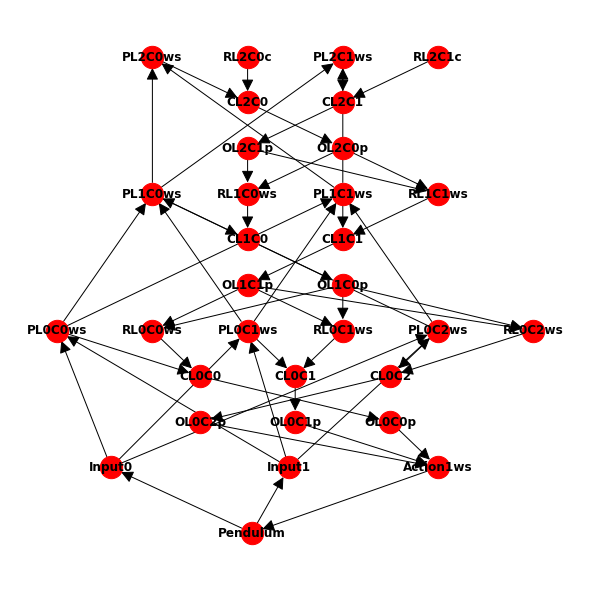

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2, 3]
config = {'level0': [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]], 'level1': [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]], 'level2': [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]]}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[0], [0]], [60.92750637861888], [[1]]]
level1 [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]]


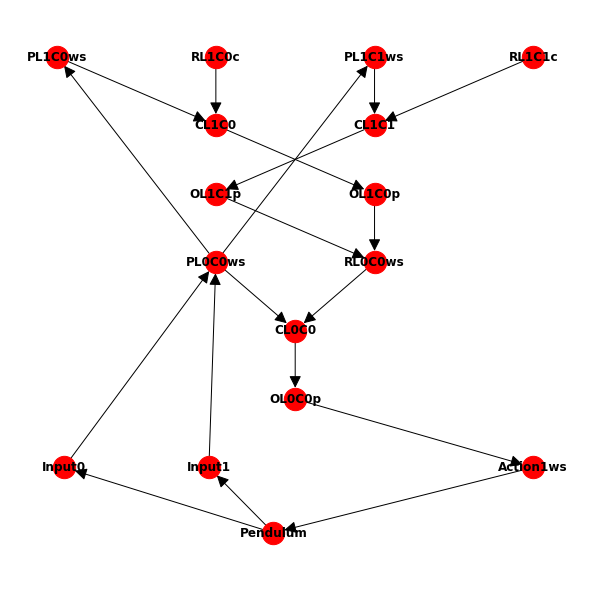

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2, 3]
config = {'level0': [[[0], [0]], [60.92750637861888], [[1]]], 'level1': [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]]}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[1]], [62.82423385532463], [[0]], [1]]


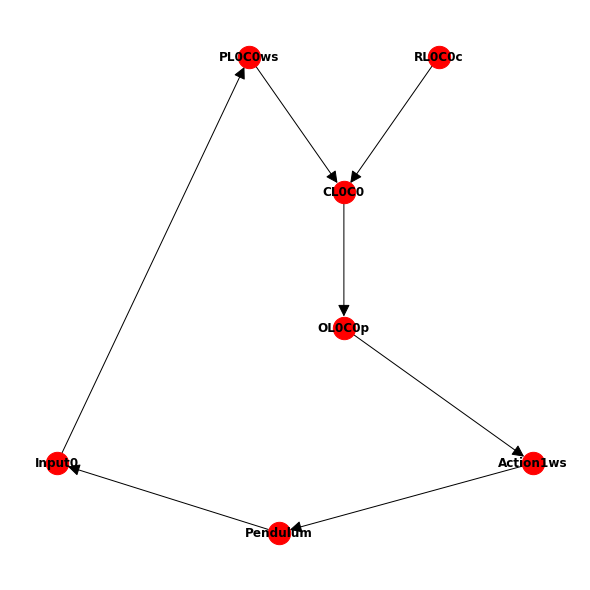

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2]
config = {'level0': [[[1]], [62.82423385532463], [[0]], [1]]}
for key in config.keys():
    print(key, config[key])
    
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0]})

In [ ]:
notebook2script()

Converted 00_examples.ipynb.
Converted 01_putils.ipynb.
Converted 02_functions.ipynb.
Converted 03_nodes.ipynb.
Converted 04_hierarchy.ipynb.
Converted 05_environments.ipynb.
Converted 06_architectures.ipynb.
Converted index.ipynb.
